# Final Project

## Team Members
- Reham Abuarqoub, 9062922
- Erica Holden, 5490685
- Yu-Chen Chou (Tracy), 9006160 

## Tasks

* Clustering: Cluster launches by decade.
* Classification: Predict whether a mission will be successful or fail based on features like launch vehicle, country, payload, etc.
* Regression: Predict payload mass or cost based on mission details.
* Probabilistic Reasoning: Estimate the probability of mission success given country and vehicle type.

In [22]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Cleaning the Data

In [5]:
# Load dataset
df = pd.read_csv('./data/Space_Corrected.csv')

# Define a class for cleaning the space mission dataset
class DataCleaner:
    def __init__(self, df):
        self.df = df

    def clean(self):
        df = self.df.copy()
        df.columns = df.columns.str.strip()

        # Remove unnecessary fields
        df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, errors='ignore')
        
        # Remove missing values
        df = df.dropna(subset=['Status Mission', 'Rocket'])

        # Convert “Rocket” column to numeric
        df['Rocket'] = pd.to_numeric(df['Rocket'], errors='coerce')

        # Convert 'Datum' column to datetime format
        df['Datum'] = pd.to_datetime(df['Datum'], errors='coerce')

        # Label unification and dualization
        df['Status Mission'] = df['Status Mission'].str.strip().str.capitalize()
        df['Mission_Success_Binary'] = df['Status Mission'].map(lambda x: 1 if x == 'Success' else 0)
        
        # Label Encoding
        categorical_cols = ['Company Name', 'Location', 'Detail']
        for c in categorical_cols:
            df[c] = df[c].astype('category')

        # Handling outliers
        df = df[df['Rocket'] >= 0]
        df = df[df['Datum'].dt.year >= 1957]

        # Remove duplicate data
        df = df.drop_duplicates()

        return df

# Create an instance of DataCleaner and clean the DataFrame 
df_clean = DataCleaner(df).clean()
df_clean.head()

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,Mission_Success_Binary
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,1
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,1
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,1
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,1
5,CASC,"LC-9, Taiyuan Satellite Launch Center, China",2020-07-25 03:13:00+00:00,"Long March 4B | Ziyuan-3 03, Apocalypse-10 & N...",StatusActive,64.68,Success,1


## Data Analysis - Normality Testing - Shapiro-Wilk Test

This is important for choosing appropriate statistical methods.

In [13]:
# Select a numeric column, e.g., Rocket_Use_Count
stat, p = shapiro(df_clean['Rocket_Use_Count'])

print('Shapiro-Wilk Test statistic:', stat)
print('p-value:', p)
if p < 0.05:
    print('Data is not normally distributed.')
else:
    print('Data is likely normally distributed.')

Shapiro-Wilk Test statistic: 0.7709658727752722
p-value: 2.8502091786941153e-34
Data is not normally distributed.


## Data Analysis - Chi Square Test & Heatmap

This shows that there are a mix of countries in Cluster 1, USA is strongest in Cluster 2, and Japan is primarily in Cluster 3.

Chi-square statistic: 1750.3814831283923
p-value: 0.0
There is a significant association between Country and Cluster.
Cluster         0    1   2
Country                   
China         156    0   0
France         95    0   0
Gran Canaria    0    2   0
India          66    0   0
Japan           2    0  38
Kazakhstan     42    0   0
New Zealand    13    0   0
Russia         54    0   0
USA            21  452   0
Yellow Sea      0    0   1


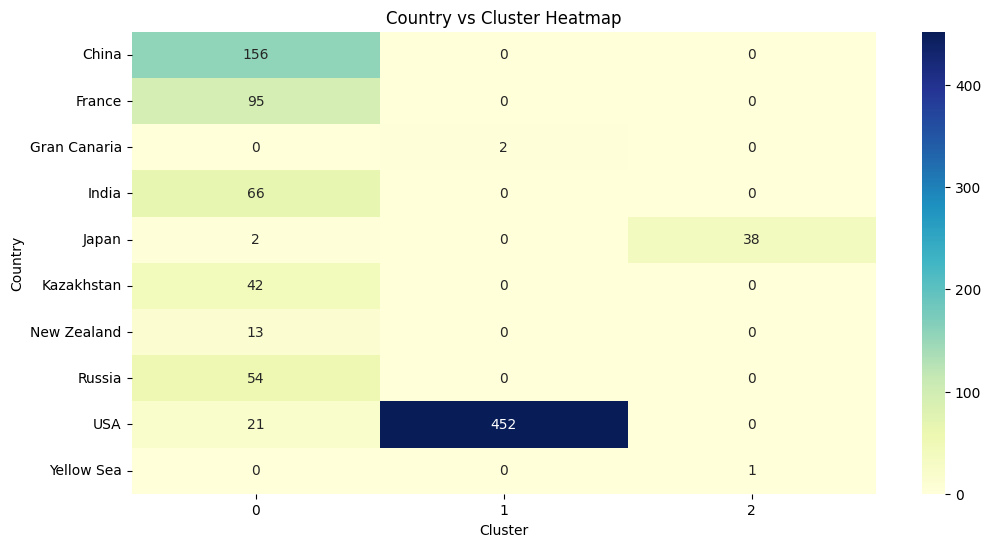

In [18]:
# Create a contingency table
contingency_table = pd.crosstab(df_clean['Country'], df_clean['Cluster'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print('Chi-square statistic:', chi2)
print('p-value:', p)
if p < 0.05:
    print('There is a significant association between Country and Cluster.')
else:
    print('No significant association between Country and Cluster.')

print(contingency_table)

plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Country vs Cluster Heatmap")
plt.xlabel("Cluster")
plt.ylabel("Country")
plt.show()

## Data Analysis - ANOVA Test & Mean Counts

This shows that there is a significant difference in Rocket_Use_Count means between clusters. Cluster 1 has the highest Rocket_Use_Count.

In [26]:
# Group Rocket_Use_Count by Cluster
groups = [group['Rocket_Use_Count'].values for name, group in df_clean.groupby('Cluster')]

# Perform one-way ANOVA
stat, p = f_oneway(*groups)

print('ANOVA F-statistic:', stat)
print('p-value:', p)
if p < 0.05:
    print('There is a significant difference in Rocket_Use_Count means between clusters.')
else:
    print('No significant difference in Rocket_Use_Count means between clusters.')

mean_counts = df_clean.groupby('Cluster')['Rocket_Use_Count'].mean()
mean_counts_df = mean_counts.reset_index()
print(mean_counts_df)

ANOVA F-statistic: 58.17773656210268
p-value: 1.516263138804233e-24
There is a significant difference in Rocket_Use_Count means between clusters.
   Cluster  Rocket_Use_Count
0        0         32.841871
1        1         59.651982
2        2         26.102564


## Clustering

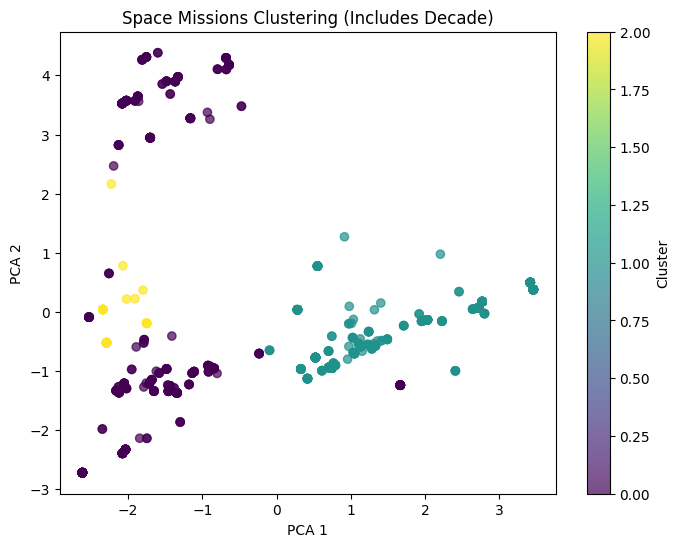

In [23]:
# Extract the decade from the date year
df_clean['Year'] = pd.to_datetime(df_clean['Datum'], errors='coerce').dt.year
df_clean['Decade'] = (df_clean['Year'] // 10) * 10

df_clean['Country'] = df_clean['Location'].str.split(',').str[-1].str.strip()
df_clean['Rocket_Family'] = df[' Rocket'].str.extract(r'([A-Za-z]+(?:\s\d+)?)') # Use original df Rocket string
df_clean['Rocket_Use_Count'] = df.groupby(' Rocket')[' Rocket'].transform('count')

# Select features for clustering
features = df_clean[['Decade', 'Country', 'Rocket_Family', 'Company Name', 'Rocket_Use_Count']]
features = features.astype(str).fillna('0')
features = features.fillna(0)

# One-hot encode categorical features
features_encoded = pd.get_dummies(features)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_encoded)

# Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters by decade
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=df_clean['Cluster'], cmap='viridis', alpha=0.7)
plt.title('Space Missions Clustering (Includes Decade)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [25]:
# Print table of cluster counts by decade
decade_cluster_counts = df_clean.groupby(['Decade', 'Cluster']).size().unstack(fill_value=0)
print(decade_cluster_counts)


Cluster    0    1   2
Decade               
1960      21    4   0
1980       8   34   0
1990      23  108   0
2000     105   96   7
2010     263  192  29
2020      29   20   3


## Summary of Clusters

| Cluster | Represents...       | Decades Active | Characteristics (Possible)      |
| ------- | ------------------- | -------------- | ------------------------------- |
| 0       | Early missions      | 1960s–1990s    | Legacy tech, early programs     |
| 1       | Standard/mainstream | 1950s–2020s    | Dominant, government-heavy      |
| 2       | Modern/emerging     | 1970s–2020s    | Private, innovative, newer tech |
